In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
import tensorflow as tf

from tensorflow.keras import layers, regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [3]:
# Let's check the imbalance rate in test, val and train DS
print(f"Train: {df_train['Occupancy'].mean():.2%}")
print(f"Val: {df_val['Occupancy'].mean():.2%}")
print(f"Test: {df_test['Occupancy'].mean():.2%}")

Train: 21.30%
Val: 36.50%
Test: 21.07%


In [4]:
# Working on im balanced DS is hard, but this data is harder because the rate of imbalance is not same for train, val and test datasets.
# In proprocessing notebook, I found that the 1 or occupied class is a lot less tham the 0 or unoccupied class in all datasets.
# In validation DS, the 1 class is even less than in train and test DS. 
# The model will become confused 😁, because it is going to be trained on one DS with different imbalance rate than the DS it is going to be validated on.

In [5]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [6]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [7]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [8]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [9]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function

window_size = 60
step_ahead = 1
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled,y_test, window_size, step_ahead)

print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8057, 60, 6) (8057,)
Val windows: (2603, 60, 6) (2603,)
Test windows: (9660, 60, 6) (9660,)


In [10]:
# The above output matches the shape of the data after creating windows
# 8117 - 30-1+1 = 8087

In [11]:
# let me to check the label.
print(np.unique(y_train_window))

[0 1]


In [12]:
# The target column is binary, and the classes are imbalanced
# one way is to use class weights during training that the model learn fairly both classes
# Counting each class  
classes, counts = np.unique(y_train_window, return_counts=True)
print("Window label counts:", dict(zip(classes, counts)))
print("Positive rate:", counts[1] / counts.sum() if len(counts) > 1 else 0.0)

# Counting class weights: 
all_classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=all_classes, y=y_train_window)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("Class weights:", class_weight)

Window label counts: {np.int64(0): np.int64(6344), np.int64(1): np.int64(1713)}
Positive rate: 0.21261015266228125
Class weights: {0: 0.6350094577553594, 1: 2.351722124927029}


<h2><center>Building CNN model<h2>

In [ ]:
def make_dilated_cnn(input_steps=60, n_features=6, l2_reg = 0.00009, drop=0.1):
    inputs = layers.Input(shape=(input_steps, n_features))
    
    x = layers.Conv1D(32, 3, padding="causal", dilation_rate=1, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.SpatialDropout1D(drop)(x)
    
    x = layers.Conv1D(32, 3, padding="causal", dilation_rate=2, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.SpatialDropout1D(drop)(x)
    
    x = layers.Conv1D(32, 3, padding="causal", dilation_rate=4, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.SpatialDropout1D(drop)(x)
    
    x = layers.Conv1D(32, 3, padding="causal", dilation_rate=8, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    return tf.keras.Model(inputs, outputs)

model = make_dilated_cnn(input_steps=60, n_features=6)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 32)         │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 60, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 60, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 60, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 60, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,953 (38.88 KB)

 Trainable params: 9,953 (38.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=3, apply_class_balancing = True), 
    metrics=[
            # This is a good option for imbalanced,       
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        tf.keras.metrics.Recall(name="recall"),])


# sources:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC

In [15]:
early_stop = EarlyStopping(monitor='val_auc_pr',   patience=10, restore_best_weights=True, verbose=1, mode= 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc_pr', factor=0.5, patience=5, verbose=1, min_lr = 0.000001, mode = 'max') 

In [16]:
history = model.fit(X_train_window, y_train_window, 
    epochs=300, batch_size=256, callbacks=[early_stop, reduce_lr],
    validation_data=(X_val_window, y_val_window), verbose=2, shuffle=True)

Epoch 1/300
32/32 - 3s - 80ms/step - auc_pr: 0.2741 - loss: 0.0382 - precision: 0.2000 - recall: 5.8377e-04 - val_auc_pr: 0.9029 - val_loss: 0.0343 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 3.0000e-04
Epoch 2/300
32/32 - 0s - 13ms/step - auc_pr: 0.8057 - loss: 0.0228 - precision: 0.8597 - recall: 0.1967 - val_auc_pr: 0.9269 - val_loss: 0.0242 - val_precision: 0.9109 - val_recall: 0.7961 - learning_rate: 3.0000e-04
Epoch 3/300
32/32 - 0s - 13ms/step - auc_pr: 0.8508 - loss: 0.0192 - precision: 0.8725 - recall: 0.5394 - val_auc_pr: 0.9453 - val_loss: 0.0202 - val_precision: 0.9388 - val_recall: 0.8586 - learning_rate: 3.0000e-04
Epoch 4/300
32/32 - 0s - 13ms/step - auc_pr: 0.8718 - loss: 0.0175 - precision: 0.8881 - recall: 0.7227 - val_auc_pr: 0.9471 - val_loss: 0.0182 - val_precision: 0.9464 - val_recall: 0.8706 - learning_rate: 3.0000e-04
Epoch 5/300
32/32 - 0s - 13ms/step - auc_pr: 0.8848 - loss: 0.0162 - precision: 0.8955 - recall: 0.7501 - val_auc_pr: 0.

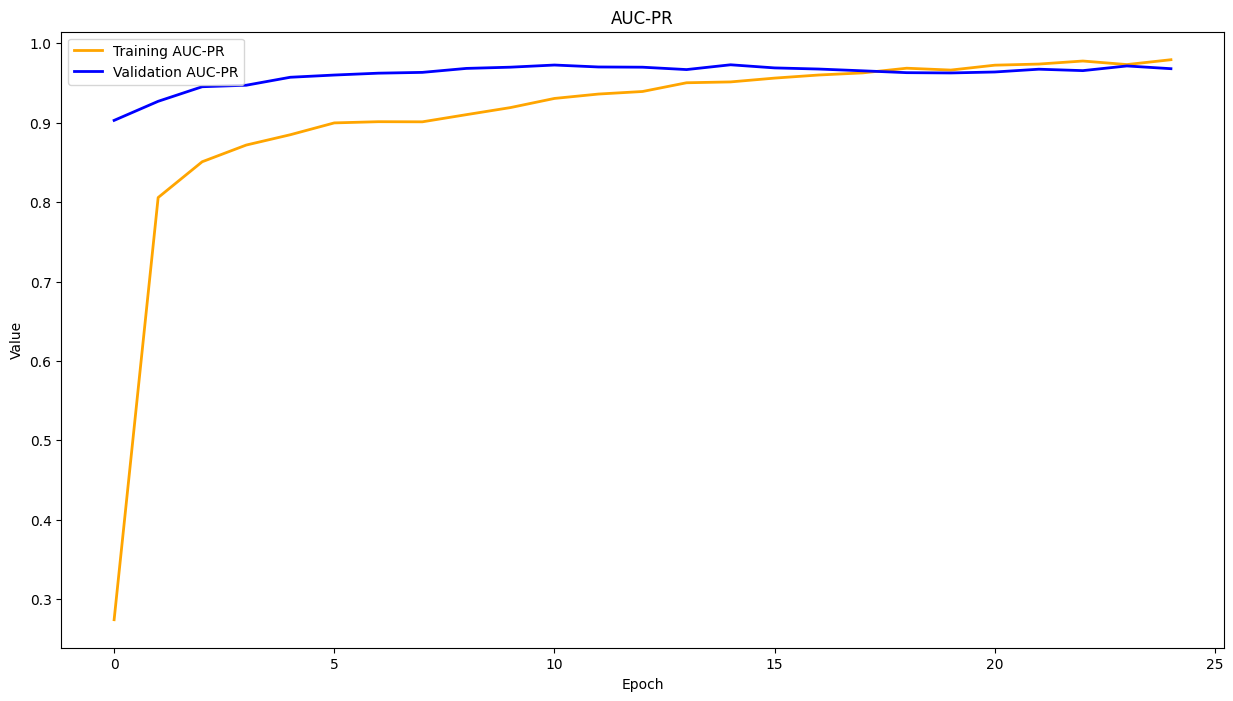

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['auc_pr'], label='Training AUC-PR', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_auc_pr'], label='Validation AUC-PR', color='blue', linewidth=2, markersize=6)
ax.set_title('AUC-PR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.legend()

In [ ]:
# Evaluating the model on test DS
Predicted_probability = model.predict(X_test_window)
# Using threshold for coverting probabilities to class labels
threshold = 0.5
Predicted_values = (Predicted_probability >= threshold).astype(int)

302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [31]:
# Evaluating the model by confusion matrix and classification report:
Confusion_Matrix = confusion_matrix(y_test_window, Predicted_values)
print("Confusion Matrix:\n", Confusion_Matrix)

Report = classification_report(y_test_window, Predicted_values, digits=2)
print("Classification Report:\n", Report)

Confusion Matrix:
 [[6973  695]
 [ 604 1388]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      7668
           1       0.67      0.70      0.68      1992

    accuracy                           0.87      9660
   macro avg       0.79      0.80      0.80      9660
weighted avg       0.87      0.87      0.87      9660



In [ ]:
# As I expected, the model can not classify correctly the 1 class,  I could combine all datasets and then split them again to have same rate of imbalance.
# But I thought that in real world scenarios, this is possible, so how I can improve the model to handle this issue?

# First the precision was too low for the 1 class, it was around 0.45, I tried many ways to improve a bit:
# - I calculated class weights and used them during training, but it did work well, because the class weight is different for train, val and test DS.
# - I used AUC mertric to focus on 1 class.
# - I used BinaryFocalCrossentropy loss which is less sensitive to class imbalance, I got a bit better result.

# Sources:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
